In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
from torch import nn
import torch.nn.functional as F
import torchzero as tz
from visualbench import FunctionDescent, test_functions

# 7. Non-linear least squares
### 7.1 Gauss-Newton
A non-linear least squares problem is a problem of the form:
$$
\underset{x}{\operatorname{argmin}} \sum_{i=1}^{m} f(x)_i^2
$$
Here instead of outputing a single value, the objective function $f$ outputs $m$ values, and the goal is to minimize the sum of their squares. Of course it is possible to simply compute sum of their squares and use any normal optimization method to minimize that scalar value. But we can minimize this problem very efficiently using the **Gauss-Newton** method which uses those $m$ values and their jacobian to estimate the hessian.

Suppose we have a function of $n$ parameters that outputs a vector $r \in \mathbb{R}^m$, this vector is called vector of **residuals**, and the goal is for all residuals to be as small as possible. Gauss-Newton uses the Jacobian matrix $J \in \mathbb{R}^{m \times n}$ of $r$ with respect to parameters $x$. It can be calculated by stacking gradients of each value $r_1, r_2, ..., r_m$ as rows of $J$. Then the Gauss-Newton step is:
$$
x_{t+1} \leftarrow x_t - \eta (J^T J)^{\dagger} J^T r
$$

Here $\eta$ is a step size which can be fixed or determined via a [line search](<../8. Line search>). $(J^T J)^{\dagger}$ means Moore-Penrose inverse (i.e. pseudoinverse) of $J^T J$. Since most of the time $m$ < $n$, then $J^T J$ has no inverse, therefore pseudo-inverse is used instead.

Same as with [Newton's method](<../4. Second order methods>), in practice the Gauss-Newton step is computed as a linear least-squares solution to a linear system because that is faster to compute:
$$
\text{solve:}\\\\ (J^T J)v_t = J^T r
$$
$$
x_{t+1} \leftarrow x_t - v_t
$$

However if $m$ < $n$, the linear system can be solved much more efficiently with this update rule:
$$
\text{solve:}\\\\ (J J^T)z_t = r
$$
$$
v_t = J^T z_t
$$
$$
x_{t+1} \leftarrow x_t - v_t
$$

To prove that $v_t$ is indeed the solution, suppose that $z$ is a solution to $(J J^T)z = r$, and suppose that $v = J^T z$. With those presuppositions we can prove that $(J^T J)v = J^T r$ by replacing $v$ with $J^T z$:
$$
(J^T J)v = (J^T J) (J^T z) = J^T (J J^T) z = J^T r
$$



For visualization we use Rosenbrock's function. The standard Rosenbrock's function is:
$$
f(x,y) = (1 - x)^2 + 100 * (y - x^2)^2
$$

You can easily see that this function is a sum of squares of two terms: $(1 - x)$ and $(y - x^2)$, and second term is multiplied by 100. So we can rewrite this function to return a vector of two residuals and solve it with Gauss-Newton:
$$
f(x, y) = [(1 - x), 100 * (y - x^2)]
$$

In torchzero to use `GaussNewton`, the closure must return a vector of residuals. The closure should not perform a backward pass, it is handled by `GaussNewton` module. The gradients are calculated in a batch which is usually much faster that a for loop.

finished in 0.1s., reached loss = 5.58e-06                                      
finished in 0.0s., reached loss = 0                                      
finished in 0.4s., reached loss = 2.4e-12                                      


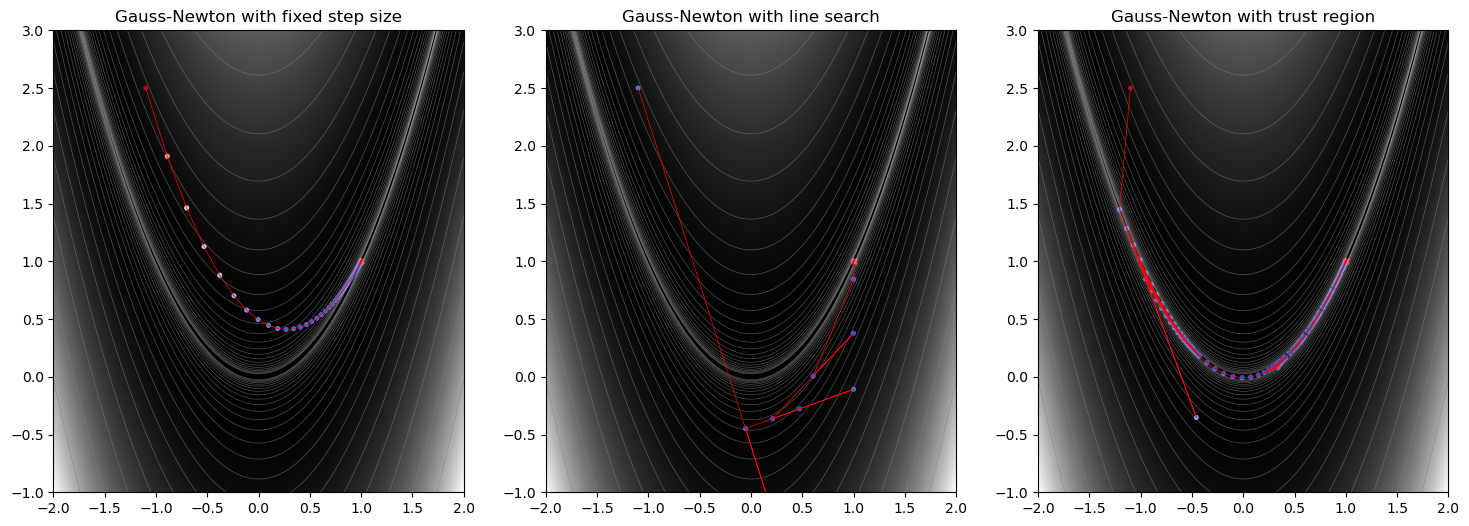

In [2]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))
ax = np.ravel(ax)

func = FunctionDescent('rosen_mo').set_multiobjective()
optimizer = tz.Optimizer(func.parameters(), tz.m.GaussNewton(), tz.m.LR(1e-1))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("Gauss-Newton with fixed step size")

func = FunctionDescent('rosen_mo').set_multiobjective()
optimizer = tz.Optimizer(func.parameters(), tz.m.GaussNewton(), tz.m.Backtracking())
func.run(optimizer, max_steps=10)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("Gauss-Newton with line search")

func = FunctionDescent('rosen_mo').set_multiobjective()
optimizer = tz.Optimizer(func.parameters(), tz.m.LevenbergMarquardt(tz.m.GaussNewton()))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("Gauss-Newton with trust region")


plt.show()

### 7.2 Levenberg-Marquardt
Levenberg-Marquardt is a trust region method (see [9. Trust region](<../9. Trust region>)) where scaled identity matrix is added to hessian or hessian approximation, in this case to Gauss-Newton approximation $J^T J$. Very often term "Levenberg-Marquardt" refers specifically to Gauss-Newton algorithm with trust region.

For Gauss-Newton approximation identity matrix is sometimes replaced with diagonal of $J^T J$, this is called modified Marquadt method[1]. In torchzero this is determined by `y` argument. If it is 0, scaled identity is used, if it is 1, diagonal of $J^T J$ is used. Values between 0 and 1 interpolate.

References:
1. [Fletcher, Roger. "A modified Marquardt subroutine for non-linear least squares." (1971).](https://epubs.stfc.ac.uk/manifestation/6683/AERE_R_6799.pdf)

finished in 0.5s., reached loss = 2.4e-12                                      
finished in 0.4s., reached loss = 3.2e-14                                      
finished in 0.3s., reached loss = 3.55e-11                                      


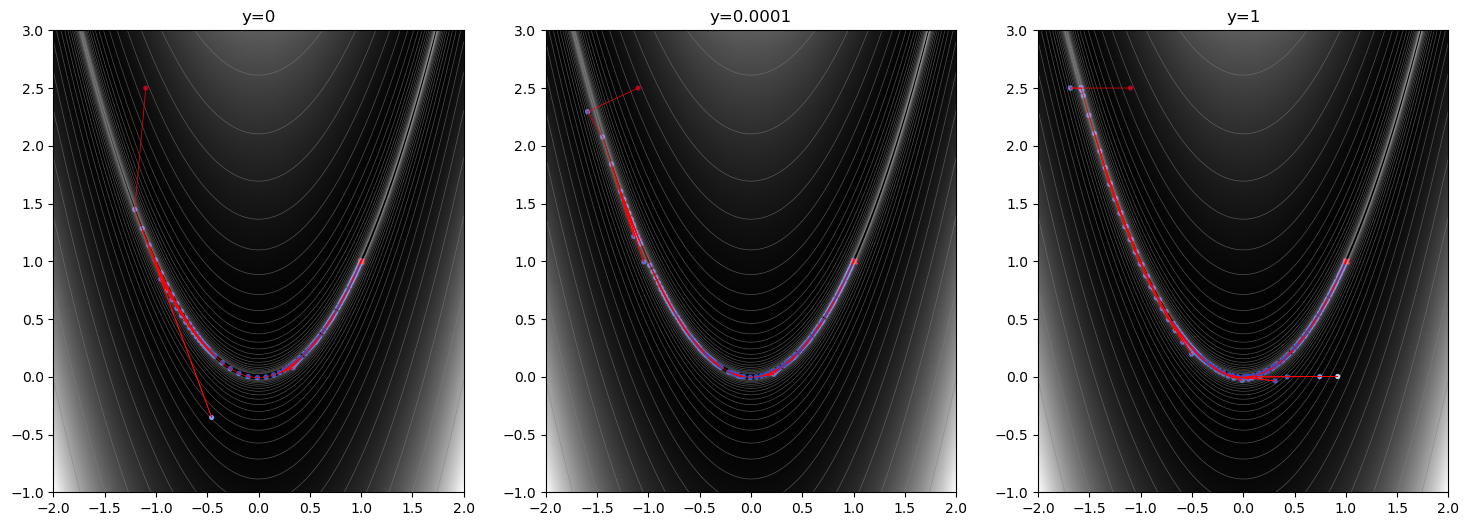

In [3]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))
ax = np.ravel(ax)

func = FunctionDescent('rosen_mo').set_multiobjective()
optimizer = tz.Optimizer(func.parameters(), tz.m.LevenbergMarquardt(tz.m.GaussNewton(), y=0))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("y=0")

func = FunctionDescent('rosen_mo').set_multiobjective()
optimizer = tz.Optimizer(func.parameters(), tz.m.LevenbergMarquardt(tz.m.GaussNewton(), y=0.0001))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("y=0.0001")

func = FunctionDescent('rosen_mo').set_multiobjective()
optimizer = tz.Optimizer(func.parameters(), tz.m.LevenbergMarquardt(tz.m.GaussNewton(), y=1))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("y=1")

plt.show()